In [1]:
#package imports
from __future__ import division

import numpy as np
import datetime
import os
from wrf import to_np, getvar, get_basemap, latlon_coords
from netCDF4 import Dataset
import pandas as pd
from datetime import timedelta
from itertools import product
import math
import xarray as xr
from numpy.lib.stride_tricks import as_strided

#functions for creating a tornado track

def getPathLength(lat1,lng1,lat2,lng2):
    '''calculates the distance between two lat, long coordinate pairs'''
    R = 6371000 # radius of earth in m
    lat1rads = math.radians(lat1)
    lat2rads = math.radians(lat2)
    deltaLat = math.radians((lat2-lat1))
    deltaLng = math.radians((lng2-lng1))
    a = math.sin(deltaLat/2) * math.sin(deltaLat/2) + math.cos(lat1rads) * math.cos(lat2rads) * math.sin(deltaLng/2) * math.sin(deltaLng/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c
    return d

def getDestinationLatLong(lat,lng,azimuth,distance):
    '''returns the lat an long of destination point 
    given the start lat, long, aziuth, and distance'''
    R = 6378.1 #Radius of the Earth in km
    brng = math.radians(azimuth) #Bearing is degrees converted to radians.
    d = distance/1000 #Distance m converted to km
    lat1 = math.radians(lat) #Current dd lat point converted to radians
    lon1 = math.radians(lng) #Current dd long point converted to radians
    lat2 = math.asin(math.sin(lat1) * math.cos(d/R) + math.cos(lat1)* math.sin(d/R)* math.cos(brng))
    lon2 = lon1 + math.atan2(math.sin(brng) * math.sin(d/R)* math.cos(lat1), math.cos(d/R)- math.sin(lat1)* math.sin(lat2))
    #convert back to degrees
    lat2 = math.degrees(lat2)
    lon2 = math.degrees(lon2)
    return[lat2, lon2]

def calculateBearing(lat1,lng1,lat2,lng2):
    '''calculates the azimuth in degrees from start point to end point'''
    startLat = math.radians(lat1)
    startLong = math.radians(lng1)
    endLat = math.radians(lat2)
    endLong = math.radians(lng2)
    dLong = endLong - startLong
    dPhi = math.log(math.tan(endLat/2.0+math.pi/4.0)/math.tan(startLat/2.0+math.pi/4.0))
    if abs(dLong) > math.pi:
         if dLong > 0.0:
             dLong = -(2.0 * math.pi - dLong)
         else:
             dLong = (2.0 * math.pi + dLong)
    bearing = (math.degrees(math.atan2(dLong, dPhi)) + 360.0) % 360.0;
    return bearing

def main(interval,lat1,lng1,lat2,lng2):
    '''returns every coordinate pair inbetween two coordinate 
    pairs given the desired interval (in meters!).'''

    d = getPathLength(lat1,lng1,lat2,lng2)
    remainder, dist = math.modf((d / interval))
    counter = float(interval)
    coords = []
    coords.append([lat1,lng1])
    
    azimuth = calculateBearing(lat1,lng1,lat2,lng2)
    
    for distance in range(0,int(dist)):
        coord = getDestinationLatLong(lat1,lng1,azimuth,counter)
        counter = counter + float(interval)
        coords.append(coord)
    coords.append([lat2,lng2])
    return np.array(coords)


def sliding_window(arr, window_size):
    """ Construct a sliding window view of the array"""
    arr = np.asarray(arr)
    window_size = int(window_size)
    if arr.ndim != 2:
        raise ValueError("need 2-D input")
    if not (window_size > 0):
        raise ValueError("need a positive window size")
    shape = (arr.shape[0] - window_size + 1,
             arr.shape[1] - window_size + 1,
             window_size, window_size)
    if shape[0] <= 0:
        shape = (1, shape[1], arr.shape[0], shape[3])
    if shape[1] <= 0:
        shape = (shape[0], 1, shape[2], arr.shape[1])
    strides = (arr.shape[1]*arr.itemsize, arr.itemsize,
               arr.shape[1]*arr.itemsize, arr.itemsize)
    return as_strided(arr, shape=shape, strides=strides)


def cell_neighbors(arr, i, j, d):
    """Return d-th neighbors of cell (i, j)"""
    w = sliding_window(arr, 2*d+1)
    ix = np.clip(i - d, 0, w.shape[0]-1)
    jx = np.clip(j - d, 0, w.shape[1]-1)
    i0 = max(0, i - d - ix)
    j0 = max(0, j - d - jx)
    i1 = w.shape[2] - max(0, d - i + ix)
    j1 = w.shape[3] - max(0, d - j + jx)
    return w[int(ix), int(jx)][int(i0):int(i1),int(j0):int(j1)].ravel()

def rmse(observed, modeled):
    #classic rmse
    observed = observed.flatten()
    modeled = modeled.flatten()
    return np.sqrt(((observed - modeled) ** 2).mean())


def rmse_ref(observed, modeled):
    #for fss denominator
    total_gridcells = len(observed.flatten())
    return np.sqrt((np.nansum(observed**2) + np.nansum(modeled**2))/total_gridcells)


def mse(observed, modeled):
    #classic rmse
    observed = observed.flatten()
    modeled = modeled.flatten()
    return ((observed - modeled) ** 2).mean()


def mse_ref(observed, modeled):
    #for fss denominator
    total_gridcells = len(observed.flatten())
    return (np.nansum(observed**2) + np.nansum(modeled**2))/total_gridcells


def compute_sns(ob_file, model_file, points):
    
    a = np.arange(0,1000,1)
    
    odd_values = a[a%2==1]
    num_of_grids_square = (a[a%2==1])**2
    
    d_record = np.zeros(odd_values.shape)
    d2_record = np.zeros(odd_values.shape)
    
    for counter, (d, num_square) in enumerate(zip(a[:odd_values.shape[0]], num_of_grids_square)):
        
        save_m = []
        save_o = []
        
        for counter_2, p in enumerate(points):
            
            wut1 = cell_neighbors(model_file, p[0], p[1], d=d)
            wut2 = cell_neighbors(ob_file, p[0], p[1], d=d)
            
            if len(wut1) == num_square:
            
                #model
                fraction_model = np.nansum(wut1)/len(wut1)
                save_m.append(fraction_model)
            
                #observed
                fraction_ob = np.nansum(wut2)/len(wut2)
                save_o.append(fraction_ob)
            
        save_m = np.array(save_m)
        save_o = np.array(save_o)
        
        d_record[counter] = 1 - (rmse(save_o, save_m)/rmse_ref(save_o, save_m))
        d2_record[counter] = 1 - (mse(save_o, save_m)/mse_ref(save_o, save_m))
        
    return d_record, d2_record

In [12]:
#computation choosing

wrf_file_folder_choice = 'wrf4km_ens_1'
#wrf_file_folder_choice = 'wrf4km_ens_2'
#wrf_file_folder_choice = 'wrf4km_ens_3'
#wrf_file_folder_choice = 'wrf4km_ens_4'
#wrf_file_folder_choice = 'wrf4km_ens_5'
#wrf_file_folder_choice = 'wrf4km_ens_6'

choice_res = np.array([80])[0]

UH_thresholds = np.array([40,40,40])

dbz_thresholds = np.array([50,40,30])


#UH_thresholds = np.array([100,100,100,80,80,80,60,60,60,40,40,40])

#dbz_thresholds = np.array([50,40,30,50,40,30,50,40,30,50,40,30])


Tors = pd.read_csv(r'/glade/work/molina/DATA/jan2017_synoptic/1950-2017_actual_tornadoes_fixed.csv',
                   error_bad_lines=False,
                   parse_dates=[['mo','dy','yr','time']])

Tors = Tors.assign(UTC_time = Tors['mo_dy_yr_time'] + timedelta(hours=6))       
Tors = Tors.assign(UTC_yr = Tors['UTC_time'].dt.year) 
Tors = Tors.assign(UTC_dy = Tors['UTC_time'].dt.day) 
Tors = Tors.assign(UTC_mo = Tors['UTC_time'].dt.month) 
Tors = Tors.assign(UTC_hr = Tors['UTC_time'].dt.hour) 

Tors = Tors[(Tors['UTC_mo']==1)]
Tors = Tors[(Tors['UTC_yr']==2017)]

Tors = Tors[(Tors['UTC_dy']==21)&(Tors['UTC_hr']>=9)|
            (Tors['UTC_dy']==22)|
            (Tors['UTC_dy']==23)&(Tors['UTC_hr']<=9)]

Tors = Tors[Tors['slat']!=0]
Tors = Tors[Tors['slon']!=0]
Tors = Tors[(Tors['slat']>=20) & (Tors['slat']<=50)]
Tors = Tors[(Tors['slon']>=-130) & (Tors['slon']<=-65)]

T_elat = [Tors['slat'].values[u] if i==0 else i for u, i in enumerate(Tors['elat'].values)]
T_elon = [Tors['slon'].values[u] if i==0 else i for u, i in enumerate(Tors['elon'].values)]

Tors = Tors.assign(corr_elat = T_elat)
Tors = Tors.assign(corr_elon = T_elon)

Tors = Tors.set_index(['UTC_time']) 


for UH_threshold, dbz_threshold in zip(UH_thresholds, dbz_thresholds):

    file2_wrf_d02 = '/glade/scratch/molina/WRF_HYSPLIT_proj/'+wrf_file_folder_choice+'/wrfout_d01_2017-01-15_09:00:00'
    ncfile2_wrf_d02 = Dataset(file2_wrf_d02)
    while True:
        dbz2_wrf_d02 = np.array([0])
        if len(dbz2_wrf_d02) == 1:
            try: 
                dbz2_wrf_d02 = getvar(ncfile2_wrf_d02, "dbz")
            except ValueError:
                continue
        if len(dbz2_wrf_d02) != 1:
            print('File Opened...')
            break
    lats4, lons4 = latlon_coords(dbz2_wrf_d02)
    m = get_basemap(dbz2_wrf_d02)
    xMax, yMax = m(m.urcrnrlon, m.urcrnrlat) 
    xMin, yMin = m(m.llcrnrlon, m.llcrnrlat) 
    x_range = (xMax-xMin) / 1000 
    y_range = (yMax-yMin) / 1000 
    
    numXGrids = round(x_range / choice_res + .5,0) 
    numYGrids = round(y_range / choice_res + .5,0)
    xi = np.linspace(xMin, xMax, int(numXGrids))
    yi = np.linspace(yMin, yMax, int(numYGrids))
    aggregate_grid = np.zeros((yi.shape[0]-1, xi.shape[0]-1)) 

    for tor_lat1, tor_lon1, tor_lat2, tor_lon2 in zip(Tors['slat'].values, Tors['slon'].values, Tors['corr_elat'].values, Tors['corr_elon'].values): 

        if tor_lat1 == tor_lat2:
            x_values = tor_lon1
            y_values = tor_lat1
            x_proj, y_proj = m(x_values, y_values) 
            grid, _, _ = np.histogram2d([y_proj], [x_proj], bins=[yi, xi]) 
            aggregate_grid[:,:] += grid > 0 

        if tor_lat1 != tor_lat2:

            coords = main(10000, tor_lat1, tor_lon1, tor_lat2, tor_lon2)        
            y_values = coords[:,0]
            x_values = coords[:,1]
            x_proj, y_proj = m(x_values, y_values)
            grid, _, _ = np.histogram2d(y_proj, x_proj, bins=[yi, xi]) 
            aggregate_grid[:,:] += grid > 0
        
    print('Tors finished.')
    
    
    #########################################################################################
    #########################################################################################
    #########################################################################################


    #create the range of dates to loop thru wrf files
    begdate = datetime.datetime.strptime('2017012109',"%Y%m%d%H") 
    enddate = datetime.datetime.strptime('2017012309',"%Y%m%d%H") 
    monthstr = datetime.datetime.strftime(begdate,"%B")
    #format into strings
    bmonth = '%02d' % begdate.month
    bday = '%02d' % begdate.day
    bbday = begdate.day
    #loop thru hours
    dates = []
    while begdate < enddate:
      dates.append(begdate)
      begdate+=datetime.timedelta(hours=1) 

    uvv_coarse = np.zeros((len(dates),yi.shape[0]-1, xi.shape[0]-1))

    counter = 0

    for count, dt in enumerate(dates):

      YY = dt.year

      MM = "%02d"%dt.month
      DD = "%02d"%dt.day
      HH = "%02d"%dt.hour

      HH_current = dt.hour

      if count != 0:
          if HH_current != HH_previous:    
              counter += 1

      wrffile = '/glade/scratch/molina/WRF_HYSPLIT_proj/'+wrf_file_folder_choice+'/wrfout_d01_2017-'+MM+'-'+DD+'_'+HH+':00:00'

      if os.path.isfile(wrffile)==True:

        ncfile = Dataset(wrffile)

        uvv = getvar(ncfile, "updraft_helicity", meta=False)
        uvv_val = uvv

        uvv2 = xr.open_dataset(wrffile, decode_cf=True).UP_HELI_MAX.values[0,:,:]
        uvv2_val = uvv2

        dbz = getvar(ncfile, "dbz", meta=False)
        dbz_val = dbz[0,:,:]

        for i, j in product(range(0,uvv2.shape[0]), range(0,uvv2.shape[1])):

            max_UH = np.nanmax([uvv_val[i,j],uvv2_val[i,j]])

            if max_UH >= UH_threshold and dbz_val[i,j] >= dbz_threshold:

                latsnow, lonsnow = to_np(lats4)[i,j], to_np(lons4)[i,j]
                x_proj,y_proj = m(lonsnow, latsnow)
                grid, _, _ = np.histogram2d(np.array([y_proj]),np.array([x_proj]), bins=[yi,xi])

                uvv_coarse[counter,:,:] += grid > 0

      else:

        print("file doesn't exist", os.path.basename(ncfile))

      HH_previous = dt.hour

      print(str(dt)+' complete...')

    print('UH and DBZ finished.')

    x1, y1 = xi, yi

    x2 = np.zeros(x1.shape)
    y2 = np.zeros(y1.shape)
    x3 = np.zeros(x1.shape)
    y3 = np.zeros(y1.shape)

    for i, j in product(range(len(x1)),range(len(y1))):

        x2[i], y2[j] = m(x1[i], y1[j], inverse=True)

        x2[i] = x2[i]-0.4
        y2[j] = y2[j]-0.4

        x3[i], y3[j] = m(x2[i], y2[j])

    file_tors = np.where(aggregate_grid == 0., aggregate_grid, 1)

    file_uhdbz = np.where(np.nansum(uvv_coarse, axis=0) == 0., np.nansum(uvv_coarse, axis=0), 1)        

    x4, y4 = x3[1:], y3[1:]

    uvv_coarse1 = np.nansum(uvv_coarse, axis=0)


    the_mask = xr.open_dataset('/glade/work/molina/DATA/usstates_shapefiles/conus_mask_res_80.nc')
    file_tors_pts = []
    for k, (i, j) in enumerate(product(range(0,file_tors.shape[0]),range(0,file_tors.shape[1]))):
        if the_mask['conus'].values[i,j]:
            file_tors_pts.append((i,j))

    file_tors_pts = np.array(file_tors_pts)

    uhdbz_forrmse_notone = uvv_coarse1[the_mask['conus'].values]
    uhdbz_forrmse_one = file_uhdbz[the_mask['conus'].values]
    tors_forrmse_notone = aggregate_grid[the_mask['conus'].values]
    tors_forrmse_one = file_tors[the_mask['conus'].values]

    rmse_notone = rmse(tors_forrmse_notone, uhdbz_forrmse_notone)
    rmse_one = rmse(tors_forrmse_one, uhdbz_forrmse_one)      

    uhdbz_forsns_notone = np.where(the_mask['conus'].values, uvv_coarse1, 0)
    uhdbz_forsns_one = np.where(the_mask['conus'].values, file_uhdbz, 0)
    tors_forsns_notone = np.where(the_mask['conus'].values, aggregate_grid, 0)
    tors_forsns_one = np.where(the_mask['conus'].values, file_tors, 0)    

    sns_notone, fss_notone = np.array(compute_sns(tors_forsns_notone, uhdbz_forsns_notone, file_tors_pts))
    sns_one, fss_one = np.array(compute_sns(tors_forsns_one, uhdbz_forsns_one, file_tors_pts))


    ###############################################################################
    ###############################################################################
    ###############################################################################


    final_filed = xr.Dataset({'UHdbz_nomask':(['y','x'], uvv_coarse1),
                              'UHdbz_mask':(['y','x'], uhdbz_forsns_notone),
                              'UHdbz_one_nomask':(['y','x'], file_uhdbz),
                              'UHdbz_one_mask':(['y','x'], uhdbz_forsns_one),

                              'tors_nomask':(['y','x'], aggregate_grid),
                              'tors_mask':(['y','x'], tors_forsns_notone),
                              'tors_one_nomask':(['y','x'], file_tors),
                              'tors_one_mask':(['y','x'], tors_forsns_one),

                              'rmse_notone':(rmse_notone),
                              'rmse_one':(rmse_one),

                              'sns_notone':(sns_notone),
                              'sns_one':(sns_one),

                              'fss_notone':(fss_notone),
                              'fss_one':(fss_one),                              
                              },

                              coords={'lon':(['x'],x4),
                                      'lat':(['y'],y4)},

                              attrs={'File Author':'Maria J. Molina'})


    final_filed.to_netcdf('/glade/work/molina/DATA/jan2017_synoptic/'+wrf_file_folder_choice+'/ver_grid_80_UH_'+str(UH_threshold)+'_Z_'+str(dbz_threshold)+'.nc')


###############################################################################
###############################################################################
###############################################################################

File Opened...
Tors finished.
2017-01-21 09:00:00 complete...
2017-01-21 10:00:00 complete...
2017-01-21 11:00:00 complete...
2017-01-21 12:00:00 complete...
2017-01-21 13:00:00 complete...
2017-01-21 14:00:00 complete...
2017-01-21 15:00:00 complete...
2017-01-21 16:00:00 complete...
2017-01-21 17:00:00 complete...
2017-01-21 18:00:00 complete...
2017-01-21 19:00:00 complete...
2017-01-21 20:00:00 complete...
2017-01-21 21:00:00 complete...
2017-01-21 22:00:00 complete...
2017-01-21 23:00:00 complete...
2017-01-22 00:00:00 complete...
2017-01-22 01:00:00 complete...
2017-01-22 02:00:00 complete...
2017-01-22 03:00:00 complete...
2017-01-22 04:00:00 complete...
2017-01-22 05:00:00 complete...
2017-01-22 06:00:00 complete...
2017-01-22 07:00:00 complete...
2017-01-22 08:00:00 complete...
2017-01-22 09:00:00 complete...
2017-01-22 10:00:00 complete...
2017-01-22 11:00:00 complete...
2017-01-22 12:00:00 complete...
2017-01-22 13:00:00 complete...
2017-01-22 14:00:00 complete...
2017-01-22

/glade/work/molina/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:116: RuntimeWarning: Mean of empty slice.
/glade/work/molina/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/glade/work/molina/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in double_scalars
/glade/work/molina/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:129: RuntimeWarning: Mean of empty slice.
/glade/work/molina/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:135: RuntimeWarning: invalid value encountered in double_scalars


File Opened...
Tors finished.
2017-01-21 09:00:00 complete...


KeyboardInterrupt: 

In [8]:
uvv_coarse1[the_mask['conus'].values].shape


(453,)

In [11]:
34*37

1258

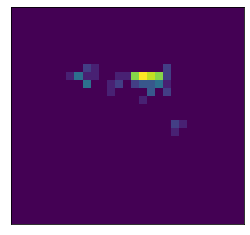

In [75]:
#import matplotlib.pyplot as plt
#m.pcolormesh(xi, yi, aggregate_grid);plt.show()

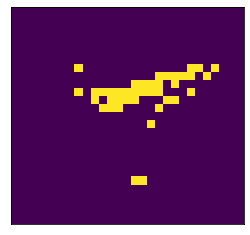

In [12]:
#m.pcolormesh(xi, yi, file_uhdbz);plt.show()

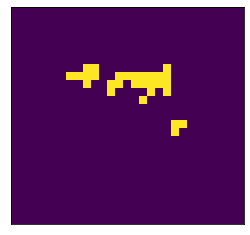

In [13]:
#m.pcolormesh(xi, yi, file_tors);plt.show()

In [53]:
#one=tors_forrmse_one[(tors_forrmse_one==1)|(uhdbz_forrmse_one==1)]

In [54]:
#two=uhdbz_forrmse_one[(tors_forrmse_one==1)|(uhdbz_forrmse_one==1)]

In [62]:
#import numpy as np
#from sklearn import metrics
#fpr, tpr, thresholds = metrics.roc_curve(one, two)
#metrics.auc(fpr, tpr)

0.14814814814814814

In [25]:
#uhdbz_roc = uhdbz_forrmse_one[(tors_forrmse_one!=0.)|(uhdbz_forrmse_one!=0.)]

In [26]:
#tors_roc = tors_forrmse_one[(tors_forrmse_one!=0.)|(uhdbz_forrmse_one!=0.)]